# Kaczmarek Kacper
Jakiś wstęp potem



---
# Procesowanie sygnału
#### 1. Zaciągnięcie danych z bazy https://physionet.org/content/gaitpdb/1.0.0/
#### 2. Zaczytanie danych
#### 3. Przedstawienie danych
---

### Zaczytanie pakietów

In [25]:
import pandas as pd
import utils
import importlib
importlib.reload(utils)
print('Packages imported')

Packages imported


### Zaczytanie danych

#### Zaczytanie metadanych

In [26]:
import pandas as pd
patients = pd.read_csv('Data/demographics.txt', sep='\\t')

         ID Study  Group  Subjnum  Gender  Age  Height  Weight  HoehnYahr  \
0    GaPt03    Ga      1        3       2   82    1.45    50.0        3.0   
1    GaPt04    Ga      1        4       1   68    1.71     NaN        2.5   
2    GaPt05    Ga      1        5       2   82    1.53    51.0        2.5   
3    GaPt06    Ga      1        6       1   72    1.70    82.0        2.0   
4    GaPt07    Ga      1        7       2   53    1.67    54.0        3.0   
..      ...   ...    ...      ...     ...  ...     ...     ...        ...   
161  SiCo26    Si      2       26       1   60    1.74    72.0        NaN   
162  SiCo27    Si      2       27       1   67    1.90    95.0        NaN   
163  SiCo28    Si      2       28       1   61    1.70    72.0        NaN   
164  SiCo29    Si      2       29       1   53    1.70    87.0        NaN   
165  SiCo30    Si      2       30       1   63    1.74    82.0        NaN   

     UPDRS  UPDRSM   TUAG  Speed_01  Speed_02  Speed_03  Speed_04  Speed_05

C:\Users\kacperk\AppData\Local\Temp\ipykernel_15416\2086926179.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  patients = pd.read_csv('Data/demographics.txt', sep='\\t')


#### Zaczytanie danych o pacjentach

In [27]:
col_names = ['SUM', 'FILENAME']
data_file_colum_names = ['Time', 'L1', 'L2', 'L3', 'L4', 'L5', 'L6', 'L7', 'L8','R1', 'R2', 'R3', 'R4', 'R5', 'R6', 'R7', 'R8', 'Force_Left', 'Force_Right']
sums = pd.read_csv('Data/SHA256SUMS.txt', header=None, sep=' ', names=col_names)
all_filenames = sums['FILENAME']
filenames = all_filenames[all_filenames.str.contains(r'\d.txt$')]
records = {}
for filename in filenames:
    patientID = utils.getPatientID(filename)
    measureNumber = utils.getMeasureNumber(filename)
    if patientID not in records:
        records[patientID] = {}
    records[patientID][f'data{measureNumber}'] = pd.read_csv(f'Data/{filename}', header=None, sep='\t', names=data_file_colum_names)

### Prezentacja danych

#### Przykład zdrowego i chorego i rozkład sił na lewej i prawej stopie

There is 12119 records in healthy
There is 12119 records in parkinson


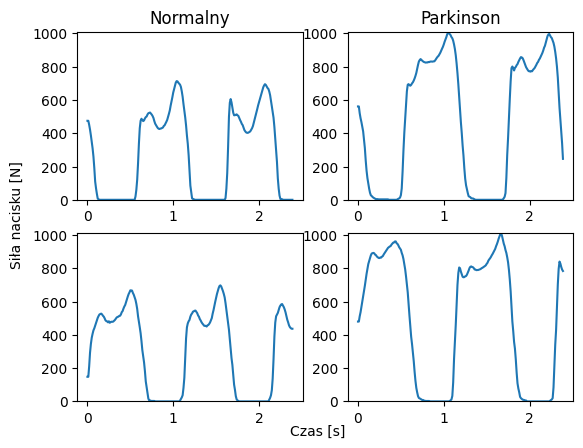

In [28]:
import matplotlib.pyplot as plt
healthy_patient_id = "GaCo16"
parkinson_patient_id = "GaPt26"
sample_number = 240

healthy_record = records[healthy_patient_id]["data1"]
parkinson_record = records[parkinson_patient_id]["data1"]

print( f'There is {len(healthy_record)} records in healthy')
x_healthy_left = healthy_record.Time.head(sample_number)
y_healthy_left = healthy_record.Force_Left.head(sample_number)
x_healthy_right = healthy_record.Time.head(sample_number)
y_healthy_right = healthy_record.Force_Right.head(sample_number)

print( f'There is {len(parkinson_record)} records in parkinson')
x_parkinson_left = parkinson_record.Time.head(sample_number)
y_parkinson_left = parkinson_record.Force_Left.head(sample_number)
x_parkinson_right = parkinson_record.Time.head(sample_number)
y_parkinson_right = parkinson_record.Force_Right.head(sample_number)

y_lim_value = pd.concat([y_healthy_left, y_healthy_right, y_parkinson_left, y_parkinson_right]).max()

fig, axs = plt.subplots(2, 2)
healthy_plot_left = axs[0,0]
healthy_plot_left.set_title('Normalny')
healthy_plot_left.plot(x_healthy_left, y_healthy_left)
healthy_plot_left.set_ylim(0, y_lim_value)
parkinson_plot_left = axs[0,1]
parkinson_plot_left.set_title('Parkinson')
parkinson_plot_left.plot(x_parkinson_left, y_parkinson_left)
parkinson_plot_left.set_ylim(0, y_lim_value)
healthy_plot_right = axs[1,0]
healthy_plot_right.plot(x_healthy_right, y_healthy_right)
healthy_plot_right.set_ylim(0, y_lim_value)
parkinson_plot_right = axs[1,1]
parkinson_plot_right.plot(x_parkinson_right, y_parkinson_right)
parkinson_plot_right.set_ylim(0, y_lim_value)
fig.text(0.5, 0.04, 'Czas [s]', ha='center')
fig.text(0.02, 0.5, 'Siła nacisku [N]', va='center', rotation='vertical')

plt.savefig("plots/gait-comparison.pdf", format="pdf", bbox_inches="tight")

#### Każdy czujnik dla zdrowego i chorego

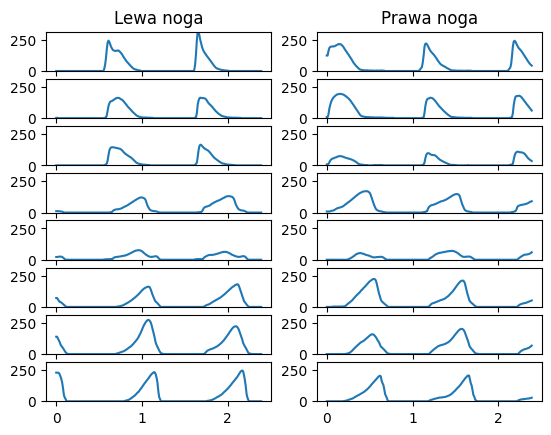

In [29]:
import utils
healthy_patient_id = "GaCo16"

healthy_record = records[healthy_patient_id]["data1"]

utils.createAllSensorPlot(healthy_record, 'healthy_all_sensors', sample_number)

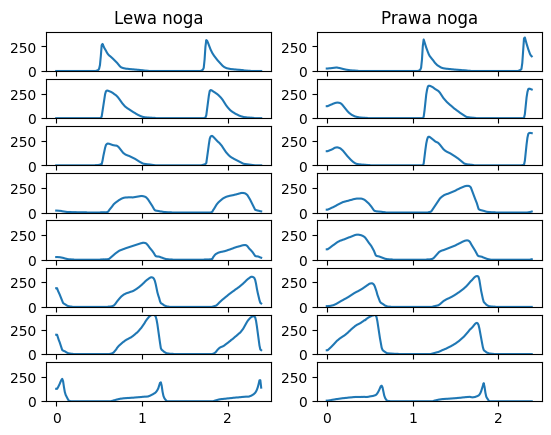

In [30]:
import utils
parkinson_patient_id = "GaPt26"

parkinson_record = records[parkinson_patient_id]["data1"]

utils.createAllSensorPlot(parkinson_record, 'parkinson_all_sensors', sample_number)

#### Wyliczenie najmniejszej porcji danych chodu

In [31]:
sample_len = float("inf")
for key, value in records.items():
    record = value['data1']
    sample_len = min(len(record.Time), sample_len)

print(sample_len)

4034


#### Prezentacja typów falek

c:\Python38\lib\site-packages\matplotlib\cbook\__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


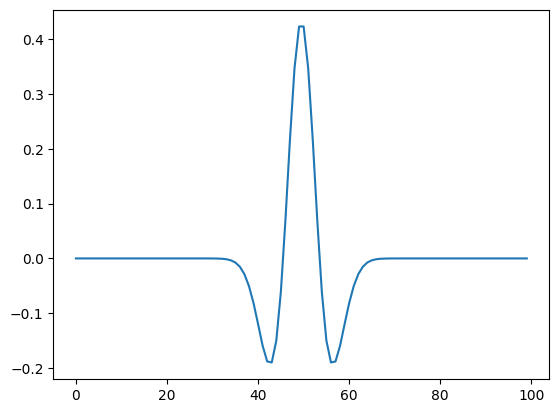

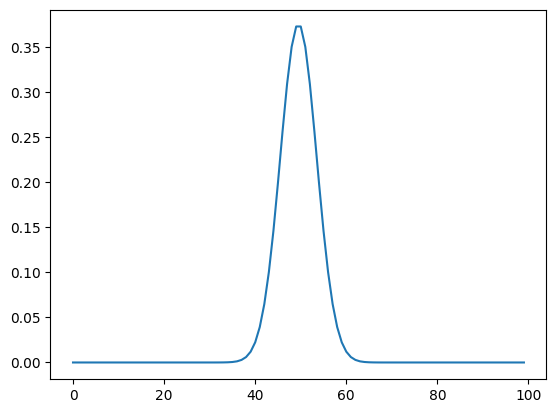

In [32]:
from scipy import signal
import matplotlib.pyplot as plt


points = 100
a = 4.0
w = 0.0

plt.figure()
vec_ricker = signal.ricker(points, a)
plt.plot(vec_ricker)

plt.savefig("plots/wavelet-type-ricker.pdf", format="pdf", bbox_inches="tight")

plt.figure()
vec_morlet2 = signal.morlet2(points, a, w)
plt.plot(vec_morlet2)

plt.savefig("plots/wavelet-type-morlet.pdf", format="pdf", bbox_inches="tight")


#### Wykresy transfomaty falkowej

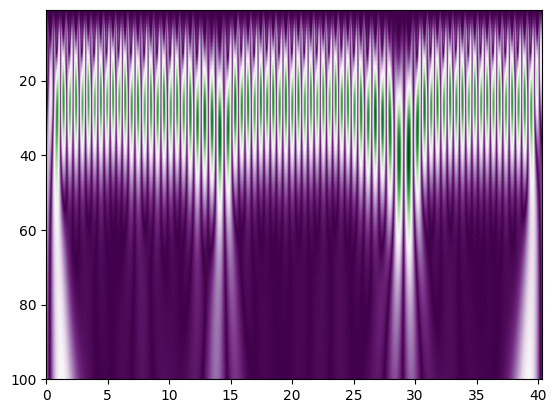

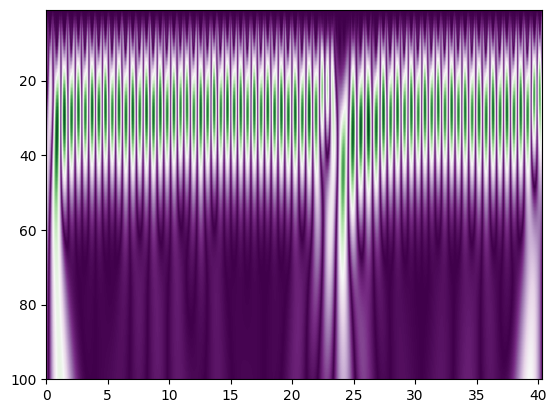

In [33]:
import matplotlib.pyplot as plt
from scipy import signal
import numpy as np

healthy_patient_id = "GaCo16"
parkinson_patient_id = "GaPt26"

healthy_record = records[healthy_patient_id]["data1"]
parkinson_record = records[parkinson_patient_id]["data1"]

sample_number = 4034

y_healthy = healthy_record.Force_Left.head(sample_number)
x_healthy = healthy_record.Time.head(sample_number)

y_parkinson = parkinson_record.Force_Left.head(sample_number)
x_parkinson = parkinson_record.Time.head(sample_number)

width = 100
widths = np.arange(1, width)
cwtmatr = signal.cwt(y_healthy, signal.ricker, widths)
plt.figure()
plt.imshow(abs(cwtmatr), extent=[0, x_healthy.values[-1], width, 1], cmap='PRGn', aspect='auto', vmax=abs(cwtmatr).max(), vmin=-abs(cwtmatr).min())
plt.savefig("plots/healthy-wavelet.pdf", format="pdf", bbox_inches="tight")

widths = np.arange(1, width)
cwtmatr = signal.cwt(y_parkinson, signal.ricker, widths)
plt.figure()
plt.imshow(abs(cwtmatr), extent=[0, x_parkinson.values[-1], width, 1], cmap='PRGn', aspect='auto', vmax=abs(cwtmatr).max(), vmin=-abs(cwtmatr).min())
plt.savefig("plots/parkinson-wavelet.pdf", format="pdf", bbox_inches="tight")

Porównanie tranformaty falkowej morleta i rickera

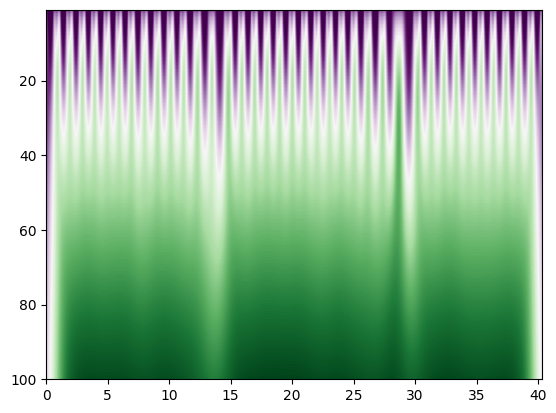

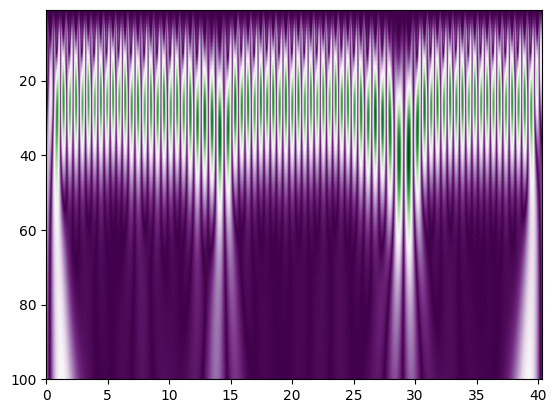

In [34]:
import matplotlib.pyplot as plt
from scipy import signal
import numpy as np

healthy_patient_id = "GaCo16"
parkinson_patient_id = "GaPt26"

healthy_record = records[healthy_patient_id]["data1"]

sample_number = 4034

y_healthy = healthy_record.Force_Left.head(sample_number)
x_healthy = healthy_record.Time.head(sample_number)


width = 100

w = 0.0
widths = np.arange(1, width)
cwtmatr = signal.cwt(y_healthy, signal.morlet2, widths, w=w)

plt.figure()
plt.imshow(abs(cwtmatr), extent=[0, x_healthy.values[-1], width, 1], cmap='PRGn', aspect='auto', vmax=abs(cwtmatr).max(), vmin=-abs(cwtmatr).min())
plt.savefig("plots/healthy-morlet.pdf", format="pdf", bbox_inches="tight")

widths = np.arange(1, width)
cwtmatr = signal.cwt(y_healthy, signal.ricker, widths)
plt.figure()
plt.imshow(abs(cwtmatr), extent=[0, x_healthy.values[-1], width, 1], cmap='PRGn', aspect='auto', vmax=abs(cwtmatr).max(), vmin=-abs(cwtmatr).min())
plt.savefig("plots/healthy-ricker.pdf", format="pdf", bbox_inches="tight")

### Klasyfikacja

#### Tworzenie obrazów do klasyfikacji

In [35]:
cond = False
if cond:
    width = 100
    widths = np.arange(1, width)
    w = 0.0
    for key, value in records.items():
        print(f'Processing ID = {key}')
        record = value['data1']
        x = record.Time.head(sample_len)
        y = record.Force_Right.head(sample_len)
        hoehnYahr = patients[patients['ID'] == key]['HoehnYahr'].values[0]
        parkinson = 'Parkinson' if hoehnYahr > 0 else 'Healthy'
        hoehnYahr = hoehnYahr if hoehnYahr > 0 else 0.0
        cwtFunc = lambda: signal.cwt(y, signal.morlet2, widths, w=w)
        utils.createWaveletPlot(x, y, parkinson, key, cwtFunc)
        utils.createWaveletPlot(x, y, hoehnYahr, key, cwtFunc)

Processing ID = JuPt03
Processing ID = GaPt15
Processing ID = GaCo08
Processing ID = GaPt14
Processing ID = JuPt01
Processing ID = JuPt28
Processing ID = JuCo06
Processing ID = GaPt24
Processing ID = SiCo22
Processing ID = JuPt29
Processing ID = SiCo16
Processing ID = JuCo19
Processing ID = GaPt28
Processing ID = JuPt24
Processing ID = SiCo11
Processing ID = GaPt08
Processing ID = GaPt20
Processing ID = GaCo09
Processing ID = GaPt26
Processing ID = SiPt29
Processing ID = SiCo01
Processing ID = SiPt14
Processing ID = SiPt18
Processing ID = SiCo28
Processing ID = SiPt20
Processing ID = JuPt06
Processing ID = JuCo04
Processing ID = GaPt31
Processing ID = SiPt38
Processing ID = JuCo24
Processing ID = GaPt19
Processing ID = JuPt20
Processing ID = GaCo13
Processing ID = SiCo03
Processing ID = JuPt23
Processing ID = SiCo24
Processing ID = SiCo04
Processing ID = JuPt04
Processing ID = GaPt09
Processing ID = JuPt09
Processing ID = JuPt15
Processing ID = GaCo01
Processing ID = JuPt17
Processing 

#### Przygotowanie zbiorów danych

In [36]:
import csv
import os
import pickle

cond = True
if cond:
    type = "Binary"
    wavelet = "Morlet"
    directory = f"{os.getcwd()}/Datasets/{type}/{wavelet}"
    output = f"{os.getcwd()}/Datasets/{type}/{wavelet}"
    split = "70/20/10"
    
    train_f = open(f"{output}_train", 'w', encoding='UTF8', newline='')
    train_writer = csv.writer(train_f)
    test_f = open(f"{output}_test", 'w', encoding='UTF8', newline='')
    test_writer = csv.writer(test_f)
    validation_f = open(f"{output}_validation", 'w', encoding='UTF8', newline='')
    validation_writer = csv.writer(validation_f)

    s = split.split('/')
    splits = {
        "train": int(s[0]),
        "test": int(s[1]),
        "validation": int(s[2])
    }

    classes = {}
    for idx, c in enumerate(os.listdir(directory)):
        classes[idx] = c

        images = os.listdir(f"{directory}/{c}")
        class_count = len(images)
        for imidx, filename in enumerate(images):
            row = [f"{c}/{filename}", idx]
            if imidx < class_count * splits["train"] / 100:
                train_writer.writerow(row)
            elif imidx < class_count * (splits["train"] + splits["test"]) / 100:
                test_writer.writerow(row)
            else:
                validation_writer.writerow(row)

    with open(f"{output}_utils", 'wb') as f:
        pickle.dump(classes, f)

    train_f.close()
    test_f.close()
    validation_f.close()

#### Uczenie sieci

In [14]:
import LearningUtils
import importlib
import os
import ModelTrainer
from torchvision import models
importlib.reload(ModelTrainer)

cond = True
if cond:
    imgdir = f"{os.getcwd()}/Datasets/Binary/Morlet"

    classes = LearningUtils.get_classes(imgdir)
    train_data_loader, validation_data_loader, test_data_loader = LearningUtils.prepare_data(imgdir)
    model_trainer = ModelTrainer.ModelTrainer(classes)
    resnet = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
    model = model_trainer.train_resnet(resnet, train_data_loader, validation_data_loader, num_epochs=100)
    model.eval()
    LearningUtils.predict_image(model, test_data_loader, classes)

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)